In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from moviepy.audio.io.AudioFileClip import AudioFileClip

2025-03-22 17:37:58.503229: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 17:37:58.608313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742665078.676349   50209 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742665078.706063   50209 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 17:37:58.837761: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# load an prepare song of choice
song_path = 'inputs'

In [3]:

def convert_to_wav(old_song_path, new_song_path):
    # Load the song file using AudioFileClip
    audio_clip = AudioFileClip(old_song_path)
    
    # Write to .wav format
    audio_clip.write_audiofile(new_song_path)

#CQT
def extract_features(audio_file_path):
    y, sr = librosa.load(audio_file_path, sr=22050, mono=True)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=512)  # Chroma representation
    time_steps = librosa.times_like(chroma[0], sr=sr)  # Get time axis for spectrogram
    return chroma, time_steps


MoviePy - Writing audio in inputs/processed/song.wav


MoviePy - Done.


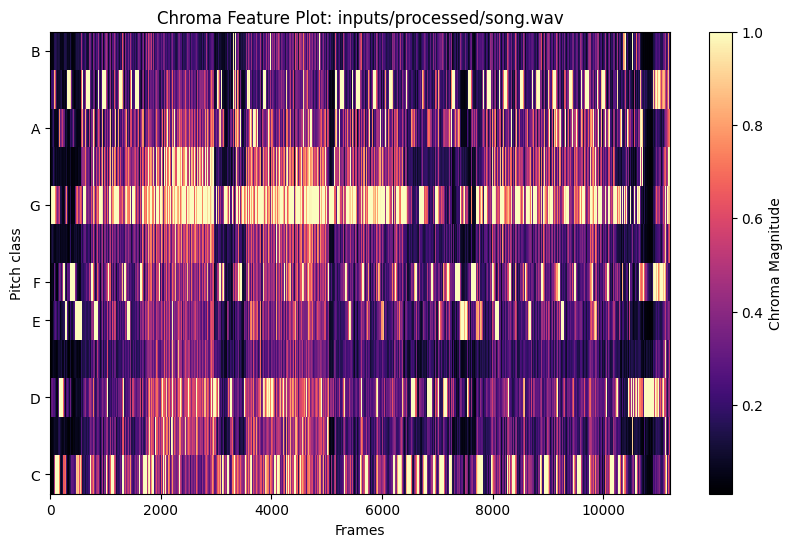

In [4]:
# Convert the song to .wav format   

for file in os.listdir(song_path):
    old_file = file
    if file.endswith('.mid'):
        new_song = os.path.join(os.path.join(song_path, 'processed'), 'song.wav')
        convert_to_wav(os.path.join(song_path, file), new_song)
        break
    elif file.endswith('.mp3'):
        new_song = os.path.join(os.path.join(song_path, 'processed'), 'song.wav')
        convert_to_wav(os.path.join(song_path, file), new_song)
        break
    elif file.endswith('.wav'):
        new_song = os.path.join(os.path.join(song_path, 'processed'), 'song.wav')
        convert_to_wav(os.path.join(song_path, file), new_song)
        break
    elif file.endswith('.flac'):
        new_song = os.path.join(os.path.join(song_path, 'processed'), 'song.wav')
        convert_to_wav(os.path.join(song_path, file), new_song)
        break
    elif file.endswith('.ogg'):
        new_song = os.path.join(os.path.join(song_path, 'processed'), 'song.wav')
        convert_to_wav(os.path.join(song_path, file))
        break
    else :
        print('Invalid file format')
        break

# Extract chroma features
chroma, sr = extract_features(new_song)

# Plotting the chroma features
plt.figure(figsize=(10, 6))
librosa.display.specshow(chroma, x_axis='frames', y_axis='chroma', sr=sr)
plt.colorbar(label='Chroma Magnitude')
plt.title(f'Chroma Feature Plot: {new_song}')
plt.show()


In [6]:
# Load the trained model
model = tf.keras.models.load_model('models/accordo_ai_model.keras', compile=False)
    
# Reshape input chroma features to match model's expected input shape
X_input_sample = chroma.T  # Shape: (time_steps, 12)

# Define the fixed sequence length
seq_length = 300
hop_length = 512
sample_rate = 22050

# Calculate the time duration of each timestep
time_per_timestep = hop_length / sample_rate

# Process input in overlapping chunks of 300 time steps
predictions_root = []
predictions_bass = []
predictions_triad = []
predictions_fourth = []

predicted_chord_vector = []

for i in range(0, X_input_sample.shape[0] - seq_length + 1, seq_length):
    chunk = X_input_sample[i : i + seq_length]  # Take a 300-time-step chunk
    chunk = np.expand_dims(chunk, axis=0)  # Add batch dimension (1, 300, 12)
    
    # Predict using the model
    predictions = model.predict(chunk, verbose=0)
    
    # Store the predicted outputs
    predictions_root.append(np.argmax(predictions[0], axis=-1))
    predictions_bass.append(np.argmax(predictions[1], axis=-1))
    predictions_triad.append(np.argmax(predictions[2], axis=-1))
    predictions_fourth.append(np.argmax(predictions[3], axis=-1))

    # Convert predictions into a single array
    predicted_root = np.concatenate(predictions_root)
    predicted_bass = np.concatenate(predictions_bass)
    predicted_triad = np.concatenate(predictions_triad)
    predicted_fourth = np.concatenate(predictions_fourth)

    # print(i)
    
    for j in range(seq_length):
        timestep = i + j
        time_in_seconds = timestep * time_per_timestep  # Convert timestep index to seconds
        root_pred = int(predicted_root[0][j])
        bass_pred = int(predicted_bass[0][j])
        triad_pred = int(predicted_triad[0][j])
        fourth_pred = int(predicted_fourth[0][j])
    
        # Print the predictions for each timestep, along with the time in seconds
        print(f"Timestep {timestep} ({time_in_seconds:.2f} seconds): [Root: {root_pred}, Bass: {bass_pred}, Triad: {triad_pred}, Fourth: {fourth_pred}]")
        predicted_chord_vector.append([round(time_in_seconds, 4), [root_pred, bass_pred, triad_pred, fourth_pred]])


chordsdf = pd.DataFrame(predicted_chord_vector, columns=['timestep', 'Chord_vector'])
print(chordsdf)

W0000 00:00:1742665115.938545   50209 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Timestep 0 (0.00 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 1 (0.02 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 2 (0.05 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 3 (0.07 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 4 (0.09 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 5 (0.12 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 6 (0.14 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 7 (0.16 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 8 (0.19 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 9 (0.21 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 10 (0.23 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 11 (0.26 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 12 (0.28 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 13 (0.30 seconds): [Root: 7, Bass: 7, Triad: 0, Fourth: 4]
Timestep 14 (0.33 seconds): [Root: 7, Bass: 7, Triad: 0, F

In [7]:
# Define categories (merging 'X' into 'N')
roots = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'N', 'X']
basses = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'N', 'X']
triads = ['Major', 'Minor', 'Diminished', 'Augmented', 'Sus2', 'Sus4', 'N', 'X']
fourths = ['dim7', 'min7', 'maj7', 'maj6', 'N', 'X']

def vector_to_chord(vector):

    chord_vocab_file = "IsoDatasetPro/chord_vocabulary_12_keys.csv"
    chord_vocab_df = pd.read_csv(chord_vocab_file)
    """
    Convert a vector of indices back to a chord label (e.g., [0, 0, 0, 1] -> 'C:maj7')
    by referring to the chord vocabulary DataFrame.
    """
    root_index, bass_index, triad_index, fourth_index = vector

    # Convert indices back to values using the corresponding arrays
    root_value = roots[root_index]
    bass_value = basses[bass_index]
    triad_value = triads[triad_index]
    fourth_value = fourths[fourth_index]

    # Find the corresponding row in the chord vocabulary
    chord_row = chord_vocab_df[
        (chord_vocab_df['root'] == root_value) &
        (chord_vocab_df['bass'] == bass_value) &
        (chord_vocab_df['triad'] == triad_value) &
        (chord_vocab_df['fourth'] == fourth_value)
    ]

    if chord_row.empty:
        # print(f"Chord with values ({root_value}, {bass_value}, {triad_value}, {fourth_value}) not found in the chord vocabulary.")
        print('Error')
        return 'N'
    else :
        # Return the chord label
        print(chord_row['chord_name'].values[0])
        return chord_row['chord_name'].values[0]

In [8]:
chordsdf['Chord_label'] = chordsdf['Chord_vector'].apply(vector_to_chord)
print(chordsdf)


G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
G:maj
C:maj/5
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:maj
C:

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [18]:

chordsdf.to_csv('Outputs/chords.csv')